# Predicting Movie Rental Durations

![dvd_image](dvd_image.jpg)

## 📖 The Background

A DVD rental company wants to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yields a MSE of `3.0` or less on a test set. The model you make will help the company become more efficient inventory planning.

## 💾 Dataset Summary

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Length of the movie being rented, in minutes.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convenience, the reference dummy has already been dropped.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
#import the data
orig_df = pd.read_csv('rental_info.csv')
#inspect the data
display(orig_df.head(5))
display(orig_df.info())

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


None

Upon inspecting the dataset, there are no missing values & most data types appear reasonable. The 'rental_date' & 'return_date' variables need to be converted to datetime types in order to calculate the difference between them.

In [3]:
#Create "rental_length_days" variable. First, need to convert the 'date' variables to datetime types.
df = orig_df.copy()
df['rental_date'] = pd.to_datetime(df['rental_date'])
df['return_date'] = pd.to_datetime(df['return_date'])
#Calculate difference between rental & return date in days
df['rental_length_days'] = (df['return_date'] - df['rental_date']).dt.days

Next, need to make two columns of dummy variables from the 'special_features' variable; `"Deleted Scenes"`, `"Behind the Scenes"`. Specifically, these columns should contain a value of `1` when `"Deleted Scenes"` or `"Behind the Scenes"` is present.

In [4]:
#Build the 2 new columns
df['deleted_scenes'] = 0
df['behind_the_scenes'] = 0

for i in df.index:
    #Deleted Scenes
    if "Deleted Scenes" in df.loc[i,'special_features']:
        df.loc[i,'deleted_scenes'] = 1
    #Behind the Scenes
    if "Behind the Scenes" in df.loc[i,'special_features']:
        df.loc[i,'behind_the_scenes'] = 1

#Check -- GOOD
#display(df.sample(5, random_state=22)[['special_features','deleted_scenes','behind_the_scenes']])

Next, select the feature variables for the regression model. The target variable is the newly constructed 'rental_length_days' variable. To start, the feature variables will include: 'amount', 'rental_rate', 'release_year', 'length', 'replacement_cost', 'NC-17', 'PG', 'PG-13', 'R', 'deleted_scenes', 'behind_the_scenes'.

In [5]:
#Select feature variables
X = df[['amount', 'rental_rate', 'release_year', 'length', 'replacement_cost', 'NC-17', 'PG', 'PG-13', 'R', 'deleted_scenes', 
        'behind_the_scenes', 'amount_2','length_2','rental_rate_2']]
#Designate the target variable
y = df['rental_length_days']

#Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=9)

With so many variables, linear regression is probably not a sophisticated enough algorithm to produce an error as desired (< 3.0 mean squared error). As such, a model that can better handle complex & larger datasets would be more relevant.

Feature selection is a technique that can be used to assist in such a process because it helps identify the most relevant features as well as those that are redundant or unnecessary. Moreover, feature selection can help reduce a model's complexity, improve model performance (lower error terms), & prevent overfitting.

Two machine learning techniques that utilize feature selection to lessen the complexity of datasets include lasso regression & random forest regression. Both methods will be evaluated in this project.

## Lasso Regression

Lasso regression is relevant because it can predict a continuous variable & it applies penalties in the modeling process in order to improve predictive accuracy. In applying the penalties, features that are more & less relevant become more distinguished, then the latter are removed from the model in favor of those with significant predictive power. At this point, an ordinary linear regression model, `LinearRegression()`, can be utilized in order to calculate the mean squared error.  
In the sklearn `Lasso()` function, the regularization parameter `alpha` controls the number of features that are selected. The lower this number, the weaker the regularization--how many features are dropped from the model.

Note that the `Lasso()` function does not perform feature selection on its own. To identify the features that are not deemed relevant, the coefficients of the model quantify how much each feature contributes to the model's performance. These values can be retrieved via the `.coef_` attribute. Moreover, values over zero indicate a positive contribution, so features with a coefficient of zero or less constitute the irrelevant variables.

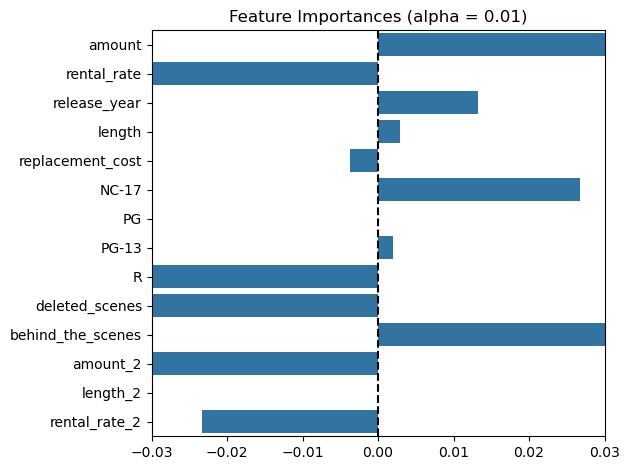

In [6]:
#Create the Lasso model
lasso = Lasso(alpha=0.01, random_state=9)

#fit the model to the training data
lasso.fit(X_train, y_train)

#zip the feature variables & their respective coefficients to see which are relevant/irrelevant
lasso_var_coefs = zip([*X.columns], lasso.coef_)
lasso_coefs = lasso.coef_

#make a visualization
ax1 = sns.barplot(dict(lasso_var_coefs), orient='h')
plt.title('Feature Importances (alpha = 0.01)')
plt.axvline(x=0, linestyle='--', color='black')
ax1.set(xlim=(-0.03, 0.03))
plt.tight_layout();

#adjust the training data to only keep the relevant variables based on the Lasso model
X_train_imp = X_train.iloc[:, lasso_coefs > 0]
X_test_imp = X_test.iloc[:, lasso_coefs > 0]

In the first trial of this Lasso process, a regularization parameter of 0.01 was used. This resulted in five of the eleven original feature variables being deemed as irrelevant because their contribution to the model, quantified through the model coefficients, was zero or less. These coefficients can be seen in the plot above. 
- In this case, these five variables include: 'rental_date', 'replacement_cost', 'PG', 'R', 'deleted_scenes'. As such, these variables will not be used in the modeling process moving forward (for linear regression).

Now that the model has been made less complex, linear regression is more applicable.


**Note:**
Subsequent trials were performed because the mean squared error in predicting the target variable, based on the feature variables used, was too high.  
Ultimately, after trialling multiple values for the regularization parameter, the mean squared error term failed to decrease to a desirable value.

In [7]:
#Create the linear regression model
lin_reg = LinearRegression()
#fit the data
lin_reg = lin_reg.fit(X_train_imp, y_train)
#cast predictions
lin_reg_pred = lin_reg.predict(X_test_imp)

#calculate the MSE
mse_lin_reg = mean_squared_error(y_test, lin_reg_pred)
display(mse_lin_reg)

4.846638768993787

With a regularization parameter of 0.01, the subsequent linear regression model had a mean squared error of about 4.847 which exceeds the desired value. As such, the parameters in this modeling process, which only consists of the regularization parameter (alpha) used in the Lasso model, need to be tuned.

The results of tuning this parameter are listed below.
- alpha = 0.01 --> MSE ~ 4.847
- alpha = 0.10 --> MSE ~ 4.842
- alpha = 0.30 --> MSE ~ 4.842
- alpha = 0.80 --> MSE ~ 4.846

As evidenced by the notes above, tuning this parameter failed to yield a desirable mean squared error term. As such, an alternative modeling process is necessary.

## Random Forest Regression

Random forest models employ multiple decision trees (models) in order to make judgments. They can be used for regression & classification. Random forest regression is applicable in this case because it is adept at handling data with non-linear relationships. With more feature variables, such relationships are more common.  
Moreover, random forest models also utilize feature selection because this process uses random samples from the data in each decision tree. Moreover, at each split point in a tree--cutoff points in the regression/classification process used to generate final predictions--only a random subset of the feature variables is utilized. Therefore, this process inherently assesses the predictive power of each feature variable.

Additionally, there are more hyperparameters involved in random forest models that can be tuned than was the case with the Lasso/Linear regression models. Cross validation can be used to help determine optimal values for these parameters. In this case, only the `n_estimators` & `max_depth` parameters were evaluated but more could also be included. Also, a five-fold random-search cross validation was utilized because it is typically more efficient in finding optimal hyperparameter values than a grid-search cross validation.
- The optimal hyperparameter values can be obtained via the `.best_params_` attribute.

In [8]:
#Create hyperparameter values to trial
params = {'n_estimators':np.arange(0,101,1), 'max_depth':np.arange(1,11,1)}

#Create the random forest model
rf_raw = RandomForestRegressor()

#Use a 5-fold random-search CV to find the optimal hyperparameter values
rand_CV = RandomizedSearchCV(rf_raw, param_distributions=params, cv=5, random_state=9)

#fit the random search CV to the data
rand_CV.fit(X_train, y_train)

#Obtain the best hyperparameter values
hyp_params = rand_CV.best_params_
display(hyp_params)

{'n_estimators': 41, 'max_depth': 10}

With a five-fold, randomized-search cross validation, the optimal hyperparameter values are:
- `n_estimators` = 41,
- `max_depth` = 10

These values will be used to create the final random forest regression model.

In [9]:
#Create the random forest model using the optimal hyperparameter values
rf = RandomForestRegressor(n_estimators=hyp_params['n_estimators'], max_depth=hyp_params['max_depth'], random_state=9)

#fit the data to the model
rf.fit(X_train, y_train)

#cast predictions
rf_pred = rf.predict(X_test)

#calculate the mean squared error
rf_mse = mean_squared_error(y_test, rf_pred)
display(rf_mse)

2.2262451838638544

From this process, the tuned random forest model produced a mean squared error of about 2.23 which is smaller than the desired error of 3.

As such, the random forest model was the better technique of the two trialled.